# Punto bonus
##### Se assumiamo che in uno specifico giorno i dati delle centraline non siano stati registrati, è possibile risalire all'informazione se in tale giorno ha piovuto / non ha piovuto o ad una stima della temperatura media guardando la distribuzione dell'occupazione dei PoI o guardando l'uso delle Verona Card?

In [1]:
def getDate(date):
    day, month, year = date.split(' ')[0].split('/')
    return '-'.join([year, month, day])

base_dir = 'dataset/'

filename_vc = base_dir + 'veronaCard.csv'
filename_w = base_dir + 'meteo.csv'

file_vc = sc.textFile(filename_vc)
file_w = sc.textFile(filename_w)

header = file_vc.first()

data_VC = file_vc.filter(lambda row: row != header)\
                    .map(lambda row : row.split(","))\
                    .filter(lambda x: x[0].split('-')[0] != '2020')\
                    .map(lambda x: (x[0], x[1], getDate(x[2]), x[4]))

data_VC.persist()

header = file_w.first() 

data_W = file_w.filter(lambda row: row != header)\
                .map(lambda row : row.split(","))\
                .map(lambda x: (x[0],int(x[1][:2]),float(x[2]),float(x[7])))\
                .filter(lambda x: x[1] < 24)\
                .filter(lambda x: x[3] > 0)\
                .filter(lambda x: x[2] < 50 and x[2] > -20)

data_W.persist()

PythonRDD[7] at RDD at PythonRDD.scala:53

Rimuovo dei giorni per poter simulare che non siano stati raccolti i dati del meteo

In [2]:
day1 = '2019-07-27'  #ore di pioggia:  [('2019-07-27', 7)]
                    #temperatura media:  [('2019-07-27', 27.61)]
day2 = '2018-11-10'  #ore di pioggia:  [('2018-11-10', 0)]
                    #temperatura media:  [('2018-11-10', 11.79)]

data_w = data_W.filter(lambda x: x[0] != day1 and x[0] != day2)
day1_w = data_W.filter(lambda x: x[0] == day1)
day2_w = data_W.filter(lambda x: x[0] == day2)

data_vc = data_VC.filter(lambda x: x[0] != day1 and x[0] != day2)
day1_vc = data_VC.filter(lambda x: x[2] == day1)
day2_vc = data_VC.filter(lambda x: x[2] == day2)


Calcolo ore di pioggia e la temperatura media per poter avere i dati reali

In [3]:
def getTestData(rdd):
    rain = rdd.map(lambda x: ((x[0],x[1]),x[3]) )\
                .reduceByKey(lambda a,b : (a+b) / 2)\
                .map(lambda x: (x[0][0], 1 if x[1]>=1 else 0))\
                .reduceByKey(lambda a,b: a+b)\
                .collect()
    temp = rdd.map(lambda x: ((x[0],x[1]),x[2]) )\
                .reduceByKey(lambda a,b : round((a + b)/2, 2))\
                .map(lambda x: (x[0][0],x[1]))\
                .reduceByKey(lambda a,b : round((a + b)/2, 2))\
                .collect()
    return rain, temp

rain1, temp1 =  getTestData(day1_w)
rain2, temp2 =  getTestData(day2_w)

print('Giorno ', day1)
print('ore di pioggia: ', rain1)
print('temperatura media: ', temp1)

print('\nGiorno ', day2)
print('ore di pioggia: ', rain2)
print('temperatura media: ', temp2)

Giorno  2019-07-27
ore di pioggia:  [('2019-07-27', 7)]
temperatura media:  [('2019-07-27', 27.61)]

Giorno  2018-11-10
ore di pioggia:  [('2018-11-10', 0)]
temperatura media:  [('2018-11-10', 11.79)]


In [4]:
def splitRain(rdd, hour_rain):
    over_X = rdd.filter(lambda x: x[1] >= hour_rain)
    under_X = rdd.filter(lambda x: x[1] < hour_rain)
    
    return (over_X, under_X)

def splitTemp(rdd, temp):
    over_Y = rdd.filter(lambda x: x[1] >= temp)
    under_Y = rdd.filter(lambda x: x[1] < temp)
    
    return (over_Y, under_Y)

Preparazione dati meteo per le funzioni di split

In [5]:
rain_hour = data_w.map(lambda x: ((x[0],x[1]),x[3]) )\
                .reduceByKey(lambda a,b : (a+b) / 2)\
                .map(lambda x: (x[0][0], 1 if x[1]>=1 else 0))\
                .reduceByKey(lambda a,b: a+b)

temp_day = data_w.map(lambda x: ((x[0],x[1]),x[2]) )\
                .reduceByKey(lambda a,b : round((a + b)/2, 2))\
                .map(lambda x: (x[0][0],x[1]))\
                .reduceByKey(lambda a,b : round((a + b)/2, 2))

day_rain, day_no_rain = splitRain(rain_hour, 1)
print('Giorni di pioggia: ', day_rain.count())
print('Giorni di \"sole\": ', day_no_rain.count())

day_hot, day_cold = splitTemp(temp_day,20)
print('Giorni caldi: ', day_hot.count())
print('Giorni freddi: ', day_cold.count())

Giorni di pioggia:  2015
Giorni di "sole":  566


Giorni caldi:  423
Giorni freddi:  2158


In [6]:
def execQ1(rdd, tot):
    list_visit = rdd.map(lambda x: (x[1],1))\
                .reduceByKey(lambda a,b: a+b)\
                .map(lambda x: (x[0],x[1] / tot * 100))\
                .sortByKey()\
                .collect()
    return list_visit


## Q1 + C1

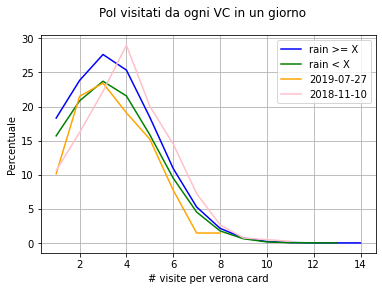

In [7]:
visit_vc = data_vc.map(lambda x: ((x[2],x[1]), 1))\
                .reduceByKey(lambda a,b: a+b)\
                .map(lambda x: (x[0][0],(x[0][1],x[1])))

#PIOGGIA
visit_vc_over = visit_vc.join(day_rain)\
                            .map(lambda x: x[1][0])

tot_vc_over = visit_vc_over.map(lambda x: x[0]).distinct().count()

list_over = execQ1(visit_vc_over, tot_vc_over)

#SOLE
visit_vc_under = visit_vc.join(day_no_rain)\
                            .map(lambda x: x[1][0])

tot_vc_under = visit_vc_under.map(lambda x: x[0]).distinct().count()

list_under = execQ1(visit_vc_under, tot_vc_under)

#GIORNI NUOVI
#1
visit_vc1 = day1_vc.filter(lambda x: x[2] == day1)\
                    .map(lambda x: ((x[2],x[1]), 1))\
                    .reduceByKey(lambda a,b: a+b)
tot1 = visit_vc1.count()

list1 = execQ1(visit_vc1, tot1)

#2
visit_vc2 = day2_vc.filter(lambda x: x[2] == day2)\
                    .map(lambda x: ((x[2],x[1]), 1))\
                    .reduceByKey(lambda a,b: a+b)
tot2 = visit_vc2.count()

list2 = execQ1(visit_vc2, tot1)

#PLOT
import matplotlib.pyplot as plt

perc_vc_over = [ x[1] for x in list_over]
perc_vc_under = [ x[1] for x in list_under]
visit_number_over = [x[0] for x in list_over]
visit_number_under = [x[0] for x in list_under]

perc_vc1 = [ x[1] for x in list1]
visit_number1 = [x[0] for x in list1]
perc_vc2 = [ x[1] for x in list2]
visit_number2 = [x[0] for x in list2]

plt.suptitle('PoI visitati da ogni VC in un giorno')
plt.xlabel('# visite per verona card')
plt.ylabel('Percentuale')

plt.grid(ls = '-')
plt.plot(visit_number_over,perc_vc_over, color='b', label= 'rain >= X')
plt.plot(visit_number_under,perc_vc_under, color='g', label= 'rain < X')
plt.plot(visit_number1, perc_vc1, color='orange', label= day1)
plt.plot(visit_number2, perc_vc2, color='pink', label= day2)
plt.legend()

plt.show()


## Q1 + C2

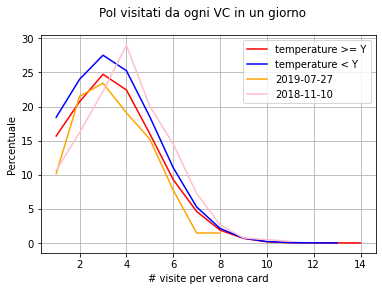

In [8]:
visit_vc = data_vc.map(lambda x: ((x[2],x[1]), 1))\
                .reduceByKey(lambda a,b: a+b)\
                .map(lambda x: (x[0][0],(x[0][1],x[1])))

#CALDO
visit_vc_over = visit_vc.join(day_hot)\
                            .map(lambda x: x[1][0])

tot_vc_over = visit_vc_over.map(lambda x: x[0]).distinct().count()

list_over = execQ1(visit_vc_over, tot_vc_over)

#FREDDO
visit_vc_under = visit_vc.join(day_cold)\
                            .map(lambda x: x[1][0])

tot_vc_under = visit_vc_under.map(lambda x: x[0]).distinct().count()

list_under = execQ1(visit_vc_under, tot_vc_under)

#GIORNI NUOVI
#1
visit_vc1 = day1_vc.filter(lambda x: x[2] == day1)\
                    .map(lambda x: ((x[2],x[1]), 1))\
                    .reduceByKey(lambda a,b: a+b)
tot1 = visit_vc1.count()

list1 = execQ1(visit_vc1, tot1)

#2
visit_vc2 = day2_vc.filter(lambda x: x[2] == day2)\
                    .map(lambda x: ((x[2],x[1]), 1))\
                    .reduceByKey(lambda a,b: a+b)
tot2 = visit_vc2.count()

list2 = execQ1(visit_vc2, tot1)

#PLOT
import matplotlib.pyplot as plt

perc_vc_over = [ x[1] for x in list_over]
perc_vc_under = [ x[1] for x in list_under]
visit_number_over = [x[0] for x in list_over]
visit_number_under = [x[0] for x in list_under]

perc_vc1 = [ x[1] for x in list1]
visit_number1 = [x[0] for x in list1]
perc_vc2 = [ x[1] for x in list2]
visit_number2 = [x[0] for x in list2]

plt.suptitle('PoI visitati da ogni VC in un giorno')
plt.xlabel('# visite per verona card')
plt.ylabel('Percentuale')

plt.grid(ls = '-')
plt.plot(visit_number_over,perc_vc_over, color='r', label = 'temperature >= Y')
plt.plot(visit_number_under,perc_vc_under, color='b', label = 'temperature < Y')
plt.plot(visit_number1, perc_vc1, color='orange', label= day1)
plt.plot(visit_number2, perc_vc2, color='pink', label= day2)
plt.legend()

plt.show()

Funzione per la suddivisione in bucket

In [9]:
number_bucket = 15
def getBucket(visitors, max_v, min_v):
    if max_v == visitors:
        return number_bucket
    
    bucket = round((max_v - min_v) / number_bucket,0)
    return int((visitors - min_v) / bucket) + 1

## Q2 + C1

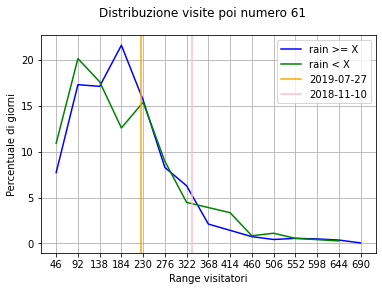

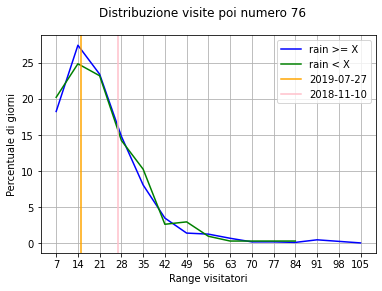

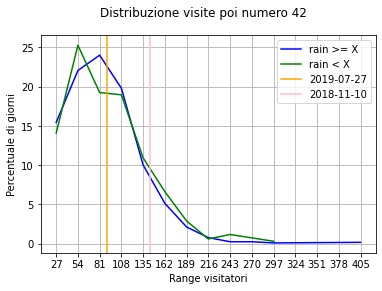

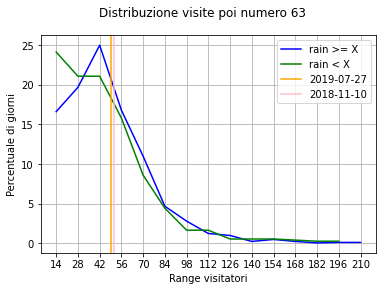

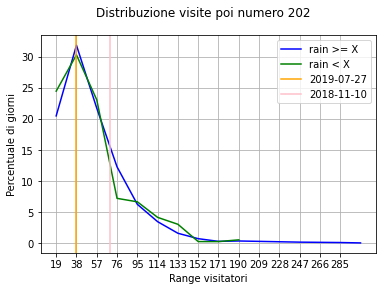

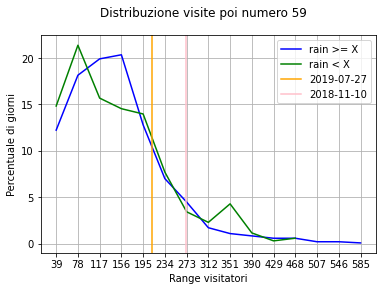

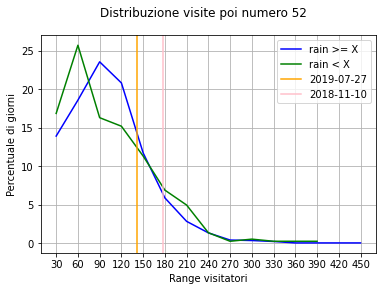

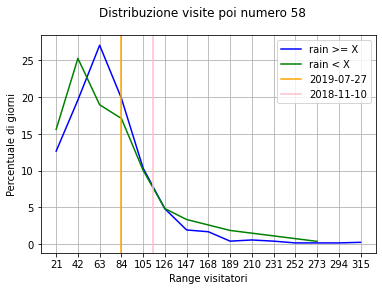

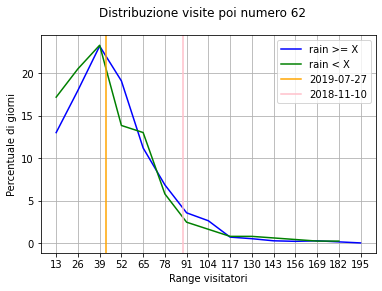

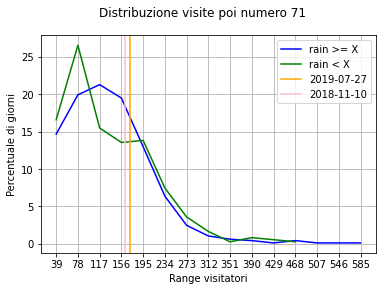

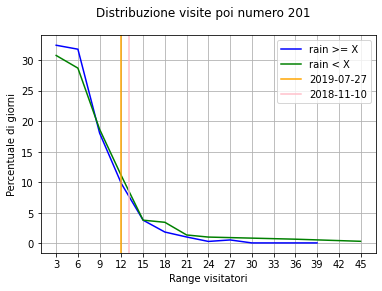

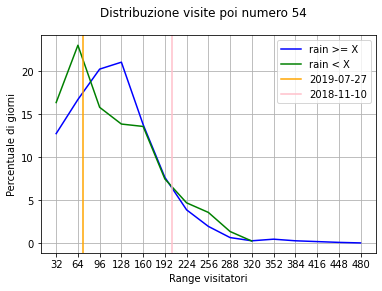

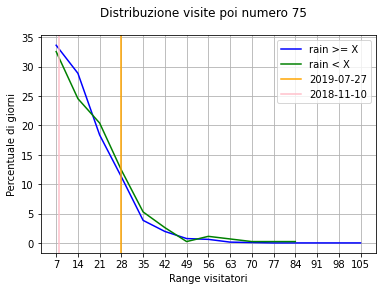

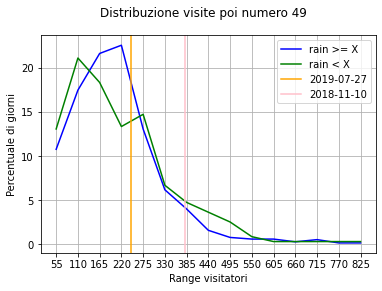

In [10]:
import matplotlib.pyplot as plt

list_poi = data_vc.map(lambda x: x[3]).distinct().collect()

daily_visitors = data_vc.map(lambda x: ((x[3],x[2].split(' ')[0]), 1))\
                            .reduceByKey(lambda a,b: a+b)
daily_visitors1 = day1_vc.map(lambda x: ((x[3],x[2].split(' ')[0]), 1))\
                            .reduceByKey(lambda a,b: a+b)
daily_visitors2 = day2_vc.map(lambda x: ((x[3],x[2].split(' ')[0]), 1))\
                            .reduceByKey(lambda a,b: a+b)

for poi in list_poi:
    count_daily = daily_visitors.filter(lambda x: x[0][0] == poi)\
                                        .map(lambda x: (x[0][1],x[1]))
    count_daily1 = daily_visitors1.filter(lambda x: x[0][0] == poi)\
                                        .map(lambda x: x[1])\
                                        .collect()
    count_daily2 = daily_visitors2.filter(lambda x: x[0][0] == poi)\
                                        .map(lambda x: x[1])\
                                        .collect()
    
    max_day = max(count_daily1[0], count_daily2[0])
    min_day = min(count_daily1[0], count_daily2[0])
    max_visitors = max(count_daily.map(lambda x: x[1]).max(), max_day)
    min_visitors = min(count_daily.map(lambda x: x[1]).min(), min_day)
    
    over_join = count_daily.join(day_rain)
    under_join = count_daily.join(day_no_rain)
    
    tot_days_over = over_join.count()
    tot_days_under = under_join.count()
    
    over_list = over_join.map(lambda x: (getBucket(x[1][0],max_visitors,min_visitors), 1))\
                            .reduceByKey(lambda a,b: a+b)\
                            .map(lambda x: (x[0], x[1] / tot_days_over * 100))\
                            .sortByKey()\
                            .collect()

    under_list = under_join.map(lambda x: (getBucket(x[1][0],max_visitors,min_visitors), 1))\
                            .reduceByKey(lambda a,b: a+b)\
                            .map(lambda x: (x[0], x[1] / tot_days_under * 100))\
                            .sortByKey()\
                            .collect()
    
    bucket = max(int(max_visitors/number_bucket), 1)
    
    visitors_over = [ x[1] for x in over_list]
    visitors_under = [ x[1] for x in under_list]
    bucket_over = [ x[0]*bucket  for x in over_list]
    bucket_under = [ x[0]*bucket  for x in under_list]

    x_labels = range(0, max_visitors,bucket)
    plt.xticks(x_labels)
        
    plt.suptitle('Distribuzione visite poi numero {}'.format(poi))
    plt.xlabel('Range visitatori')
    plt.ylabel('Percentuale di giorni')
    plt.grid()
    plt.plot(bucket_over,visitors_over,color='b',label= 'rain >= X')
    plt.plot(bucket_under,visitors_under,color='g',label= 'rain < X')
    plt.axvline(count_daily1[0], color='orange', label= day1)
    plt.axvline(count_daily2[0], color='pink', label= day2)
    plt.legend()
    
    plt.show()


## Q2 + C2

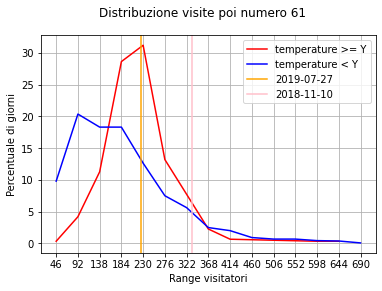

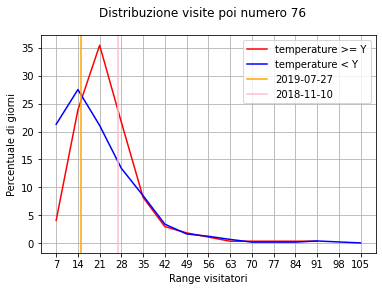

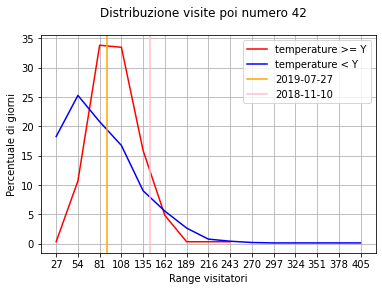

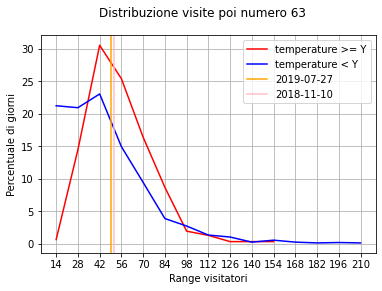

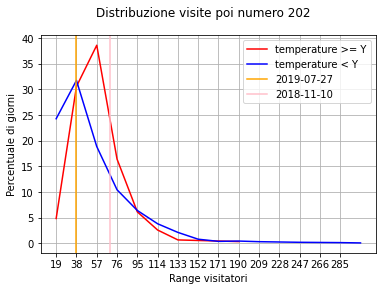

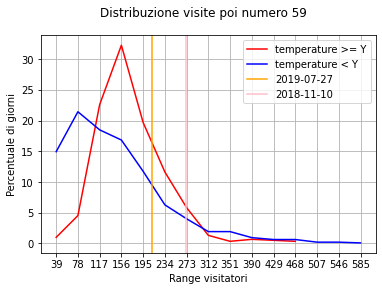

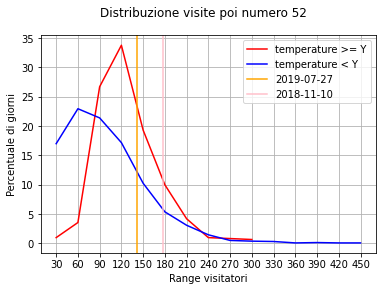

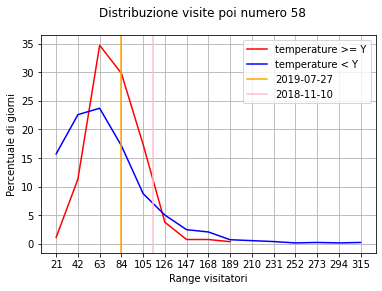

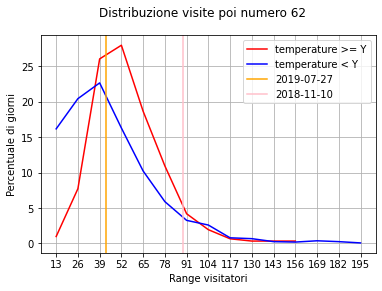

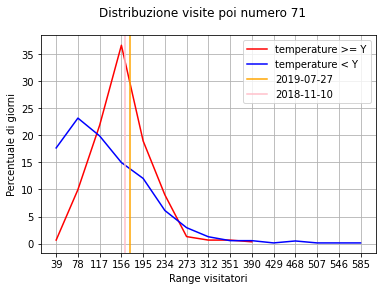

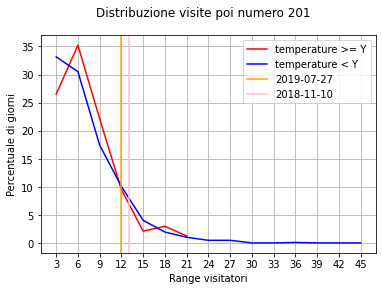

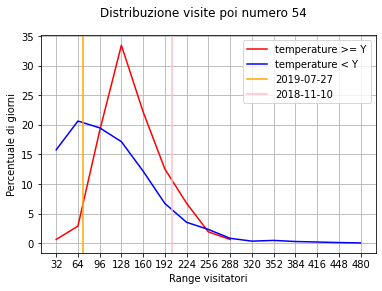

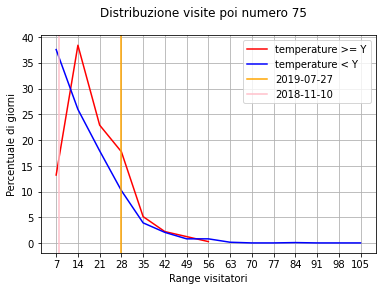

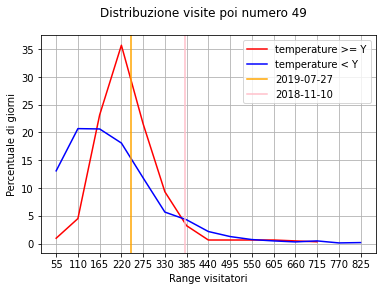

In [11]:
import matplotlib.pyplot as plt

list_poi = data_vc.map(lambda x: x[3]).distinct().collect()

daily_visitors = data_vc.map(lambda x: ((x[3],x[2].split(' ')[0]), 1))\
                            .reduceByKey(lambda a,b: a+b)
daily_visitors1 = day1_vc.map(lambda x: ((x[3],x[2].split(' ')[0]), 1))\
                            .reduceByKey(lambda a,b: a+b)
daily_visitors2 = day2_vc.map(lambda x: ((x[3],x[2].split(' ')[0]), 1))\
                            .reduceByKey(lambda a,b: a+b)

for poi in list_poi:
    count_daily = daily_visitors.filter(lambda x: x[0][0] == poi)\
                                        .map(lambda x: (x[0][1],x[1]))
    count_daily1 = daily_visitors1.filter(lambda x: x[0][0] == poi)\
                                        .map(lambda x: x[1])\
                                        .collect()
    count_daily2 = daily_visitors2.filter(lambda x: x[0][0] == poi)\
                                        .map(lambda x: x[1])\
                                        .collect()
    
    max_day = max(count_daily1[0], count_daily2[0])
    min_day = min(count_daily1[0], count_daily2[0])
    max_visitors = max(count_daily.map(lambda x: x[1]).max(), max_day)
    min_visitors = min(count_daily.map(lambda x: x[1]).min(), min_day)
    
    over_join = count_daily.join(day_hot)
    under_join = count_daily.join(day_cold)
    
    tot_days_over = over_join.count()
    tot_days_under = under_join.count()
    
    over_list = over_join.map(lambda x: (getBucket(x[1][0],max_visitors,min_visitors), 1))\
                            .reduceByKey(lambda a,b: a+b)\
                            .map(lambda x: (x[0], x[1] / tot_days_over * 100))\
                            .sortByKey()\
                            .collect()

    under_list = under_join.map(lambda x: (getBucket(x[1][0],max_visitors,min_visitors), 1))\
                            .reduceByKey(lambda a,b: a+b)\
                            .map(lambda x: (x[0], x[1] / tot_days_under * 100))\
                            .sortByKey()\
                            .collect()
    
    bucket = max(int(max_visitors/number_bucket), 1)
    
    visitors_over = [ x[1] for x in over_list]
    visitors_under = [ x[1] for x in under_list]
    bucket_over = [ x[0]*bucket  for x in over_list]
    bucket_under = [ x[0]*bucket  for x in under_list]

    x_labels = range(0, max_visitors,bucket)
    plt.xticks(x_labels)
        
    plt.suptitle('Distribuzione visite poi numero {}'.format(poi))
    plt.xlabel('Range visitatori')
    plt.ylabel('Percentuale di giorni')
    plt.grid()
    plt.plot(bucket_over,visitors_over,color='r', label = 'temperature >= Y')
    plt.plot(bucket_under,visitors_under,color='b', label = 'temperature < Y')
    plt.axvline(count_daily1[0], color='orange', label= day1)
    plt.axvline(count_daily2[0], color='pink', label= day2)
    plt.legend()
    
    plt.show()


# Con Machine Learning

In [12]:
def get_temp(t):
    if t < 0:
        return 1
    elif t < 10:
        return 2
    elif t < 20:
        return 3
    elif t < 30:
        return 4
    return 5

def get_rain(r):
    if r < 1: #"pioviggine"
        return 1
    elif r < 2: #"pioggia debole"
        return 2
    elif r < 4: #pioggia leggera
        return 3
    elif r < 6: #"pioggia moderata"
        return 4
    elif r <10: #"pioggia forte"
        return 5 
    elif r <30: #"rovescio"
        return 6 
    return 7 #"nubifragio"

In [13]:
w_mean = data_w.map(lambda x: ((x[0],x[1]),(x[2],x[3])) )\
                .reduceByKey(lambda a,b : ((a[0]+b[0]) / 2 , (a[1]+b[1]) / 2))\
                .map(lambda x: (x[0][0],x[1]))\
                .reduceByKey(lambda a,b : ((a[0]+b[0]) / 2 , (a[1]+b[1]) / 2))\
                .map(lambda x: (x[0], (get_temp(x[1][0]), get_rain(x[1][1]))))\
                .sortByKey()
w_mean.take(3)

[('2014-01-01', (2, 1)), ('2014-01-02', (2, 3)), ('2014-01-03', (2, 1))]

In [14]:
train_w, test_w = w_mean.randomSplit(weights=[0.8, 0.2], seed=1)


In [15]:
n_visit = data_vc.map(lambda x: ((x[3],x[2].split(' ')[0]), 1))\
                            .reduceByKey(lambda a,b: a+b)\
                            .map(lambda x: (x[0][1], (x[0][0], x[1])))
n_visit.take(3)

[('2017-11-29', ('61', 55)),
 ('2017-12-16', ('61', 193)),
 ('2017-10-29', ('61', 211))]

In [16]:
train_visit_weather = n_visit.join(train_w)\
            .map(lambda x: [x[0].split('-'), int(x[1][0][0]), x[1][0][1], x[1][1][0], x[1][1][1]])
test_visit_weather = n_visit.join(test_w)\
            .map(lambda x: [x[0].split('-'), int(x[1][0][0]), x[1][0][1], x[1][1][0], x[1][1][1]])

In [17]:
train_data = train_visit_weather.map(lambda x: [int(x[0][0]), int(x[0][1]), int(x[0][2]), x[1], x[2]])\
                    .collect()      #[2017, 10, 27, 61, 148]
train_target = train_visit_weather.map(lambda x: x[3:]).collect()    #[11.0, 0.2]

test_data = test_visit_weather.map(lambda x: [int(x[0][0]), int(x[0][1]), int(x[0][2]), x[1], x[2]])\
                    .collect()      #[2017, 10, 27, 61, 148]
test_target = test_visit_weather.map(lambda x: x[3:]).collect() 

In [18]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

X_train, X_test, Y_train, Y_test = train_data, test_data, train_target, test_target

n = MinMaxScaler()
X_train = n.fit_transform(X_train)
X_test = n.transform(X_test)

forest_reg = RandomForestRegressor(n_estimators=10, random_state=0)
forest_reg.fit(X_train, Y_train)

data_predictions = forest_reg.predict(X_test)

data_prediction_temperature = [x[0] for x in data_predictions]
data_prediction_rain = [x[1] for x in data_predictions]
Y_test_temperature = [x[0] for x in Y_test]
Y_test_rain = [x[1] for x in Y_test]


print('\n---------------result--------------------\n')
print('mape temperature: ', MAPE(Y_test_temperature, data_prediction_temperature), '%')
print('mape rain: ', MAPE(Y_test_rain, data_prediction_rain), '%')



---------------result--------------------

mape temperature:  10.16 %
mape rain:  81.47 %
